## Libraries

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Import datas

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X, y = data.data, data.target
y = y.reshape(-1, 1)

columns = data.feature_names
housing_df = pd.DataFrame(X, columns=columns)
housing_df['Target'] = y

print(housing_df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


# Normalizing & split

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=93)

# RBF Neural network

In [4]:
# RBF-like network (approximated using MLP with ReLU activation)
rbf_mlp_model = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=93
)
rbf_mlp_model.fit(X_train, y_train)
y_pred_rbf_mlp = rbf_mlp_model.predict(X_test)
mse_rbf_mlp = mean_squared_error(y_test, y_pred_rbf_mlp)
print("MSE of RBF-like Neural Network (MLPRegressor):", mse_rbf_mlp)

# RBF Layer for TensorFlow
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_units, centers, sigma):
        super(RBFLayer, self).__init__()
        self.num_units = num_units
        self.centers = tf.Variable(centers, trainable=False, dtype=tf.float32)
        self.sigma = tf.Variable(sigma, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        return tf.exp(-tf.reduce_sum(tf.square(diff), axis=-1) / (2 * tf.square(self.sigma)))

num_units = 100
centers = np.random.uniform(-1, 1, size=(num_units, X_train.shape[1]))
sigma = 1.0

rbf_tf_model = Sequential([
    RBFLayer(num_units=num_units, centers=centers, sigma=sigma),
    Dense(1)  # Output layer
])
rbf_tf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rbf_tf_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
mse_rbf_tf = rbf_tf_model.evaluate(X_test, y_test, verbose=0)
print("MSE of RBF Neural Network (TensorFlow):", mse_rbf_tf)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of RBF-like Neural Network (MLPRegressor): 0.27415911498441176
MSE of RBF Neural Network (TensorFlow): 0.7800415754318237


# Dense Neural network

In [5]:
# Dense network (fully connected layers)
dense_mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
dense_mlp_model.fit(X_train, y_train)
y_pred_dense_mlp = dense_mlp_model.predict(X_test)
mse_dense_mlp = mean_squared_error(y_test, y_pred_dense_mlp)
print("MSE of Dense Neural Network (MLPRegressor):", mse_dense_mlp)

# Dense Neural Network in TensorFlow
dense_tf_model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    Dense(50, activation='relu'),  # Second hidden layer
    Dense(1)  # Output layer
])
dense_tf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
dense_tf_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
mse_dense_tf = dense_tf_model.evaluate(X_test, y_test, verbose=0)
print("MSE of Dense Neural Network (TensorFlow):", mse_dense_tf)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of Dense Neural Network (MLPRegressor): 0.2565801700644592


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE of Dense Neural Network (TensorFlow): 0.27268150448799133


# Plots

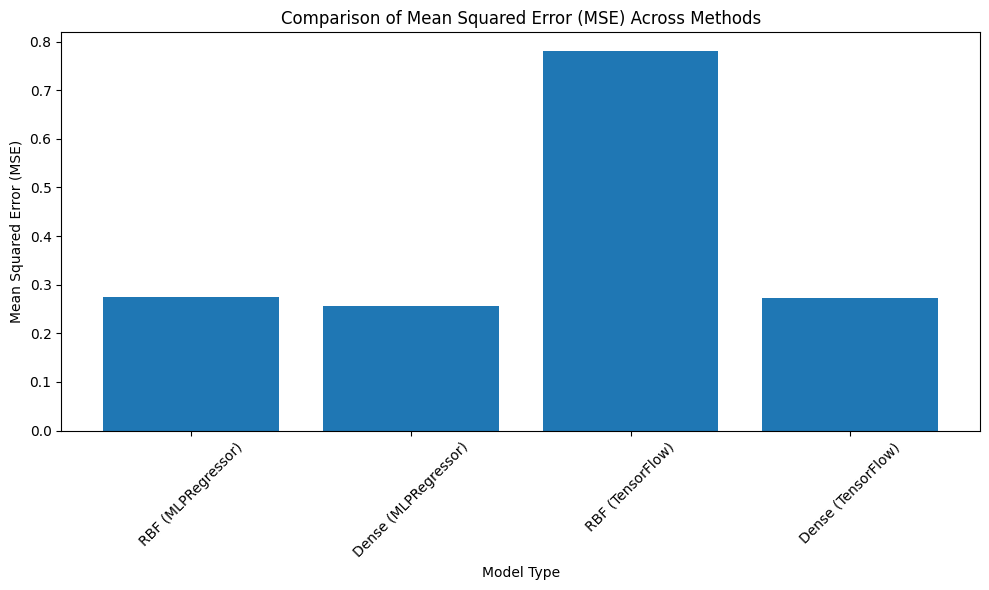

In [7]:
mse_results = {
    "RBF (MLPRegressor)": 0.27415911498441176,
    "Dense (MLPRegressor)": 0.2565801700644592,
    "RBF (TensorFlow)": 0.7800415754318237,
    "Dense (TensorFlow)": 0.27268150448799133,
}

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(mse_results.keys(), mse_results.values())
plt.title("Comparison of Mean Squared Error (MSE) Across Methods")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Model Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()